In [134]:
# Install required libraries (run once per session)
#!pip install -q einops pytorch-lightning scikit-learn
#!pip install -q git+https://github.com/yuqinie98/PatchTST.git


In [135]:
import torch
import torch.nn as nn

class PatchTST(nn.Module):
    def __init__(self, input_len, pred_len, n_features, d_model=64, n_heads=4, n_layers=3, patch_len=1, dropout=0.1):
        super().__init__()
        self.input_len = input_len
        self.pred_len = pred_len
        self.n_features = n_features

        self.patch_embed = nn.Linear(patch_len * n_features, d_model)
        self.pos_embed = nn.Parameter(torch.randn(1, input_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=4*d_model, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(input_len * d_model, pred_len)  # Flatten then predict
        )

    def forward(self, x):
        # x shape: (B, T, F)
        B, T, F = x.shape
        x = x.view(B, T, -1)  # flatten patches (1-patch = 1 timestep)
        x = self.patch_embed(x) + self.pos_embed[:, :T]
        x = self.transformer(x)
        x = self.head[0](x)           # Apply LayerNorm along d_model dim
        x = x.flatten(1)              # Then flatten time steps
        x = self.head[1](x)           # Apply final linear layer
        return x



In [136]:
import pandas as pd
import os
from glob import glob

# Mount Google Drive if using Colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:

# Set your folder path
folder_path = "/content/drive/Shareddrives/Capstone/Capstone Project NY/Cleaned Data/Final Data/All Files"

# Load all CSVs in the folder
csv_paths = glob(os.path.join(folder_path, "*.csv"))

# Load and normalize column names
dataframes = {}
for path in csv_paths:
    base = os.path.basename(path).replace("Cleaned_", "").replace("_Data.csv", "")
    df = pd.read_csv(path)

    # Normalize column casing
    df.columns = [col.lower() for col in df.columns]

    # Rename standardized code column
    if 'ccode' in df.columns:
        df = df.rename(columns={'ccode': 'Ccode'})
    elif 'country' in df.columns:
        df = df.rename(columns={'country': 'Ccode'})  # fallback if no Ccode

    df["Feature"] = base
    dataframes[base] = df



In [138]:
# STEP 1 — Convert to long format
long_dfs = []
for name, df in dataframes.items():
    melted = df.melt(id_vars=["Ccode"], var_name="Year", value_name=name)
    long_dfs.append(melted)

# STEP 2 — Merge on Ccode and Year
from functools import reduce
merged_df = reduce(lambda left, right: pd.merge(left, right, on=["Ccode", "Year"], how="outer"), long_dfs)

# STEP 3 — Clean Year column
merged_df["Year"] = merged_df["Year"].astype(str)  # ensure string
merged_df = merged_df[merged_df["Year"].str.match(r"^\d{4}$", na=False)]  # keep only valid years
merged_df["Year"] = merged_df["Year"].astype(int)  # convert to int


In [139]:
# Check unique values in 'Year' to see what's wrong
print(merged_df["Year"].unique())


[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023]


In [140]:
# Define your target column
target_col = "Public_Sector_Debt"  # Replace with the actual column name if different

# Define features (exclude ID and target)
feature_cols = [col for col in merged_df.columns if col not in ["Ccode", "Year", target_col]]


In [141]:
print(merged_df.columns.tolist())


['Ccode', 'Year', 'Annual Labor Force Survey.csv', 'filtered_urban_population(_ of total polpulation) - filtered_urban_population(_ of total polpulation).csv', 'Average Wage Data  - Average Wage Data .csv', 'filtered_corruption_score(0-100).csv', 'CPI.csv', 'Import_of_goods_services_as_percent_of_gdp_2009_2023.csv', 'export_of_goods_services_as_percent_of_gdp_2009_2023.csv', 'labor_force_participation_2009_2023.csv', 'Annual_Inflation_2009_2023.csv', 'gdp_per_capita_2009_2023.csv', 'FDI_in_USD_2009_2023.csv', 'National_GDP_USD_2009_2023.csv', 'tax_to_gdp_2009_2023.csv', 'Annual_inflation_percentage_2009_2023.csv', 'Import_of_goods_services_as_percentage_GDP_2009_2023.csv', 'Cleaned Unemployment rate 2009-2023.csv', 'Cleaned Population growth rate 2009_2023.csv', 'public sector debt_2009_2023.csv']


In [142]:
target_col = "public sector debt_2009_2023.csv"


In [143]:
# Ensure all feature columns are numeric, convert errors to NaN
merged_df[feature_cols] = merged_df[feature_cols].apply(pd.to_numeric, errors='coerce')

# Now it's safe to impute
merged_df[feature_cols] = merged_df[feature_cols].apply(lambda row: row.fillna(row.mean()), axis=1)

# Drop rows, impute, and scale
row_thresh = int(0.5 * len(feature_cols))
merged_df = merged_df.dropna(subset=feature_cols, thresh=row_thresh)
merged_df[feature_cols] = merged_df[feature_cols].apply(lambda row: row.fillna(row.mean()), axis=1)
merged_df[target_col] = merged_df[target_col].fillna(method='ffill').fillna(method='bfill')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Store unscaled actual debt separately
merged_df["Actual_Debt_Unscaled"] = merged_df[target_col]

merged_df[feature_cols] = scaler.fit_transform(merged_df[feature_cols])


<ipython-input-143-541f1f12402c>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[target_col] = merged_df[target_col].fillna(method='ffill').fillna(method='bfill')


In [163]:
merged_df.groupby("Ccode")["Actual_Debt_Unscaled"].describe()


,count,mean,std,min,25%,50%,75%,max
Ccode,,,,,,,,
AUS,15.0,2.806612e+01,1.038763e+01,7.599199,20.239260,31.624370,35.260983,4.362806e+01
AUT,15.0,5.849370e+01,2.717108e+00,52.566907,57.513473,58.948238,59.807850,6.257158e+01
Australia,15.0,2.590133e+00,1.579224e+00,0.846906,1.686774,1.948647,2.891125,6.594097e+00
Austria,15.0,2.640423e+00,2.367467e+00,0.506309,1.456403,1.998380,2.626171,8.546870e+00
BEL,15.0,8.771416e+01,2.877974e+00,82.738484,86.062848,88.467370,89.380692,9.336492e+01
...,...,...,...,...,...,...,...,...
TUR,15.0,3.132733e+09,1.213302e+10,25.637507,28.610949,30.780744,36.427285,4.699100e+10
Turkey,15.0,1.751145e+01,1.922231e+01,6.250977,7.722994,8.891570,15.754643,7.230884e+01
USA,15.0,9.040301e+01,1.676742e+01,53.406291,83.869896,88.378832,100.667209,1.170551e+02


In [144]:
# Step 5: Train/Test Split

train_df = merged_df[merged_df["Year"] <= 2021]
test_df = merged_df[merged_df["Year"] > 2021]

# Separate inputs and target
X_train = train_df[["Ccode", "Year"] + feature_cols]
y_train = train_df[["Ccode", "Year", target_col]]

X_test = test_df[["Ccode", "Year"] + feature_cols]
y_test = test_df[["Ccode", "Year", target_col]]

# Optional: save or return for model input
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)


SETTINGS

In [145]:
# Settings
input_length = 5   # how many past years to use
forecast_horizon = 1  # how many future years to predict


In [146]:
from collections import defaultdict
import numpy as np

X_seq, y_seq = [], []

# Group by country
grouped = merged_df.sort_values("Year").groupby("Ccode")

for country, group in grouped:
    values = group[feature_cols + [target_col]].values
    if len(values) < input_length + forecast_horizon:
        continue

    for i in range(len(values) - input_length - forecast_horizon + 1):
        X_seq.append(values[i:i+input_length, :-1])  # features only
        y_seq.append(values[i+input_length:i+input_length+forecast_horizon, -1])  # target only


In [147]:
import torch

X_tensor = torch.tensor(X_seq, dtype=torch.float32)  # (samples, input_len, n_features)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)  # (samples, forecast_horizon)


In [148]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


In [149]:
n_features = X_train.shape[2]
input_len = X_train.shape[1]
pred_len = y_train.shape[1]

model = PatchTST(
    input_len=input_len,
    pred_len=pred_len,
    n_features=n_features,
    d_model=64,
    n_heads=4,
    n_layers=3,
    patch_len=1
).to("cuda" if torch.cuda.is_available() else "cpu")


In [150]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define training loop
def train_model(model, train_loader, test_loader, epochs=50, lr=1e-3, patience=50):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_loss = float("inf")
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred.squeeze(), yb.squeeze())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += criterion(pred.squeeze(), yb.squeeze()).item()
        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_patchtst.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses


In [151]:
from torch.utils.data import Dataset, DataLoader

# Dataset wrapper
class PatchTSTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Wrap your tensors
train_dataset = PatchTSTDataset(X_train, y_train)
test_dataset = PatchTSTDataset(X_test, y_test)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [152]:
train_losses, val_losses = train_model(model, train_loader, test_loader, epochs=50)


Epoch 1/50 - Train Loss: 0.1473 | Val Loss: 0.0280
Epoch 2/50 - Train Loss: 0.0203 | Val Loss: 0.0057
Epoch 3/50 - Train Loss: 0.0107 | Val Loss: 0.0002
Epoch 4/50 - Train Loss: 0.0077 | Val Loss: 0.0003
Epoch 5/50 - Train Loss: 0.0067 | Val Loss: 0.0017
Epoch 6/50 - Train Loss: 0.0059 | Val Loss: 0.0014
Epoch 7/50 - Train Loss: 0.0062 | Val Loss: 0.0002
Epoch 8/50 - Train Loss: 0.0059 | Val Loss: 0.0004
Epoch 9/50 - Train Loss: 0.0046 | Val Loss: 0.0016
Epoch 10/50 - Train Loss: 0.0048 | Val Loss: 0.0001
Epoch 11/50 - Train Loss: 0.0043 | Val Loss: 0.0001
Epoch 12/50 - Train Loss: 0.0035 | Val Loss: 0.0012
Epoch 13/50 - Train Loss: 0.0043 | Val Loss: 0.0003
Epoch 14/50 - Train Loss: 0.0043 | Val Loss: 0.0001
Epoch 15/50 - Train Loss: 0.0030 | Val Loss: 0.0005
Epoch 16/50 - Train Loss: 0.0029 | Val Loss: 0.0002
Epoch 17/50 - Train Loss: 0.0028 | Val Loss: 0.0002
Epoch 18/50 - Train Loss: 0.0023 | Val Loss: 0.0005
Epoch 19/50 - Train Loss: 0.0019 | Val Loss: 0.0001
Epoch 20/50 - Train L

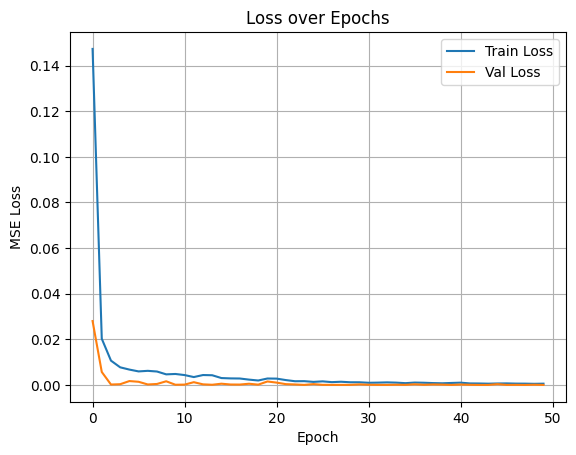

In [153]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()


In [154]:
model.load_state_dict(torch.load("best_patchtst.pt"))
model.eval()

all_preds = []
all_actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu()
        all_preds.append(preds)
        all_actuals.append(yb)

all_preds = torch.cat(all_preds).squeeze().numpy()
all_actuals = torch.cat(all_actuals).squeeze().numpy()


In [155]:
future_steps = 5
forecast_rows = []

# Use entire merged_df to grab per-country history
for country in merged_df["Ccode"].unique():
    country_hist = merged_df[merged_df["Ccode"] == country].sort_values("Year")

    # Skip countries without enough history
    if len(country_hist) < input_length:
        continue

    # Build input from most recent input_length values of all features
    feature_seq = country_hist.iloc[-input_length:][feature_cols].values
    input_window = torch.tensor(feature_seq, dtype=torch.float32).unsqueeze(0).to(device)

    last_year = country_hist["Year"].max()

    for i in range(future_steps):
        with torch.no_grad():
            next_pred = model(input_window).squeeze().cpu().item()


        forecast_rows.append({
            "Ccode": country,
            "Year": last_year + i + 1,
            "Predicted_Debt": next_pred,
            "Actual_Debt": None
        })

        # Update input with new prediction (replace last column only = target)
        new_row = input_window[:, -1, :].clone()
        new_row[:, feature_cols.index(target_col)] = torch.tensor(next_pred)
        input_window = torch.cat([input_window[:, 1:, :], new_row.unsqueeze(1)], dim=1)


In [156]:
import pandas as pd

results_df = pd.DataFrame({
    "Predicted": all_preds.flatten(),
    "Actual": all_actuals.flatten()
})

results_df.to_csv("patchtst_predictions.csv", index=False)
print(results_df.head())


   Predicted    Actual
0  -0.054558 -0.054614
1  -0.052318 -0.054614
2  -0.059650 -0.054614
3  -0.056976 -0.054614
4  -0.051894 -0.054614


In [157]:
# Rebuild metadata (ensure this matches your test set)
# You may need to pull from test_df or store these during split
ccodes = test_df["Ccode"].reset_index(drop=True)
years = test_df["Year"].reset_index(drop=True)

# Combine into DataFrame
results_df = pd.DataFrame({
    "Ccode": ccodes,
    "Year": years,
    "Predicted_Debt": all_preds,
    "Actual_Debt": all_actuals
})

# Save to CSV
results_df.to_csv("patchtst_country_predictions.csv", index=False)
results_df.head()


,Ccode,Year,Predicted_Debt,Actual_Debt
0,AUS,2022,-0.054558,-0.054614
1,AUS,2023,-0.052318,-0.054614
2,AUT,2022,-0.059650,-0.054614
3,AUT,2023,-0.056976,-0.054614
4,Australia,2022,-0.051894,-0.054614


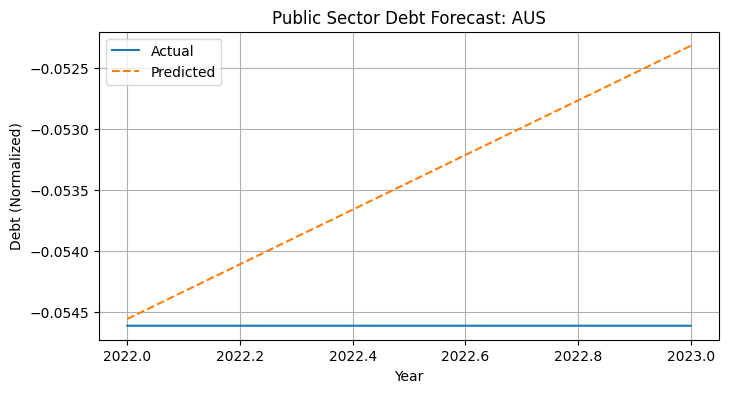

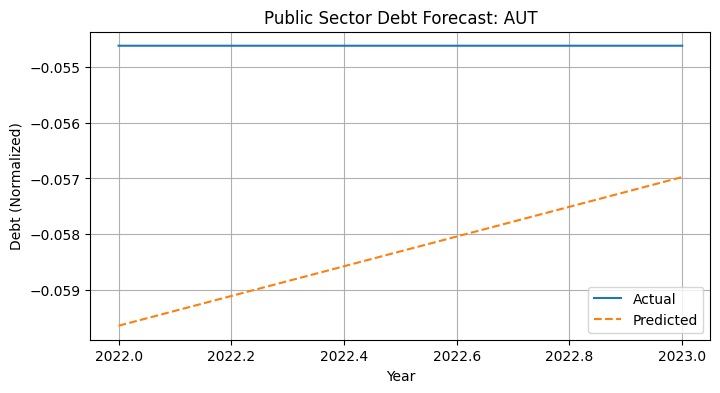

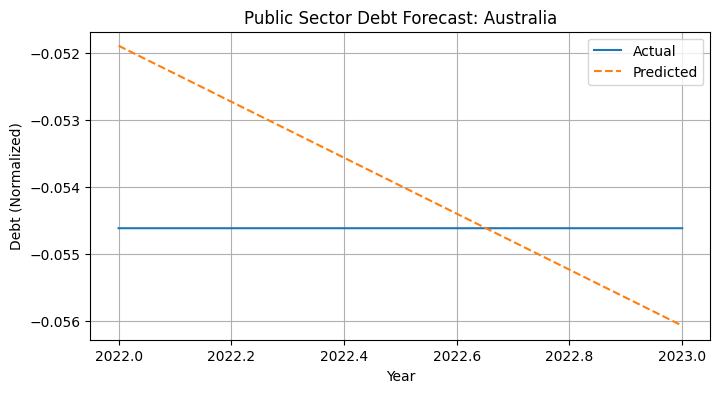

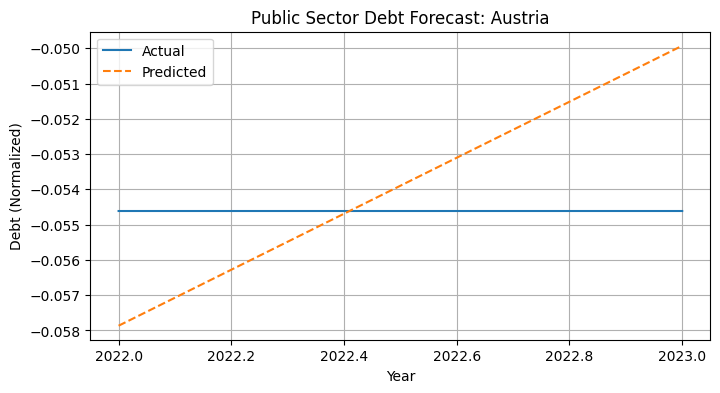

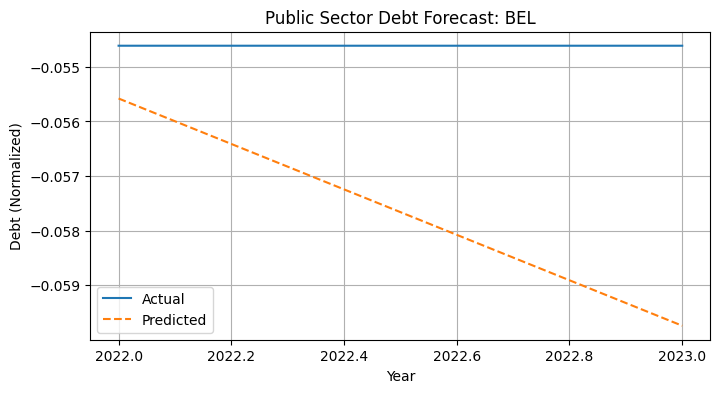

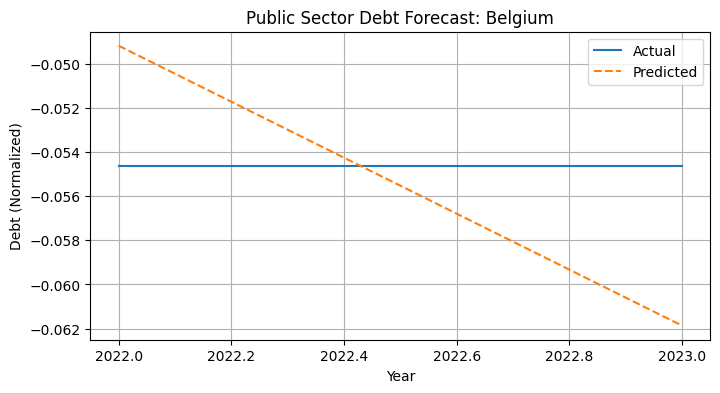

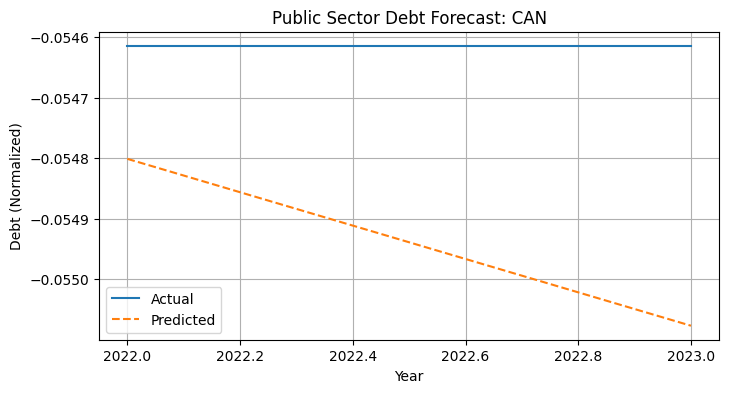

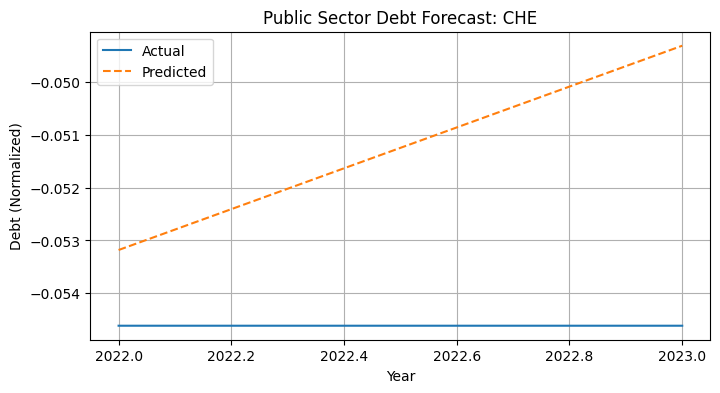

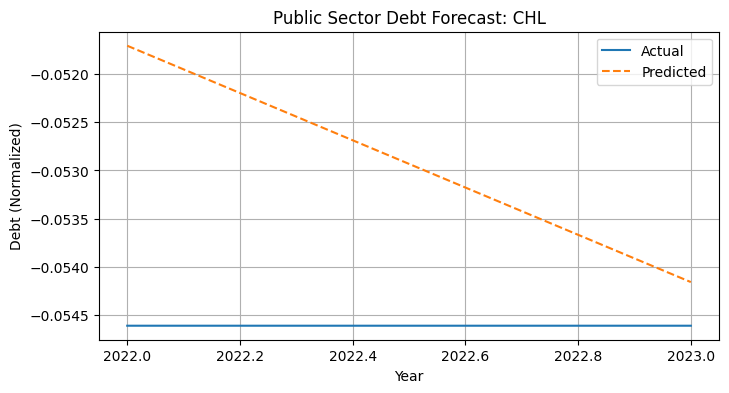

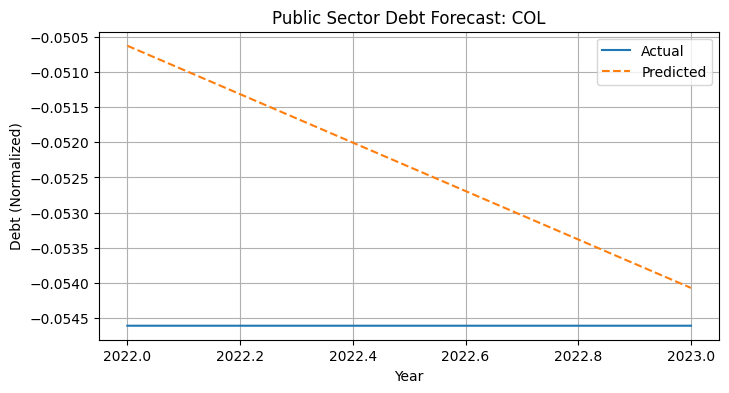

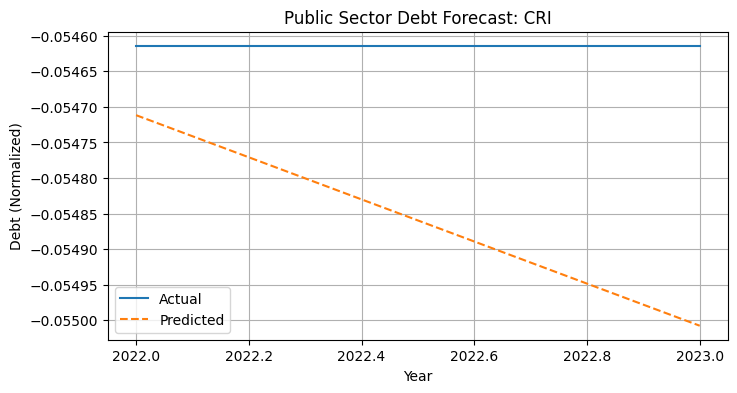

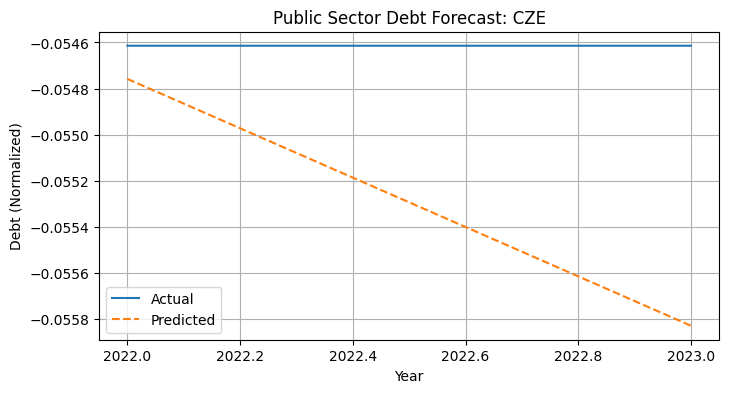

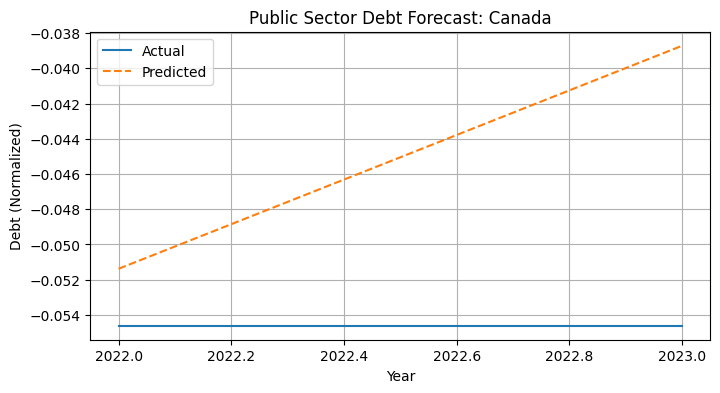

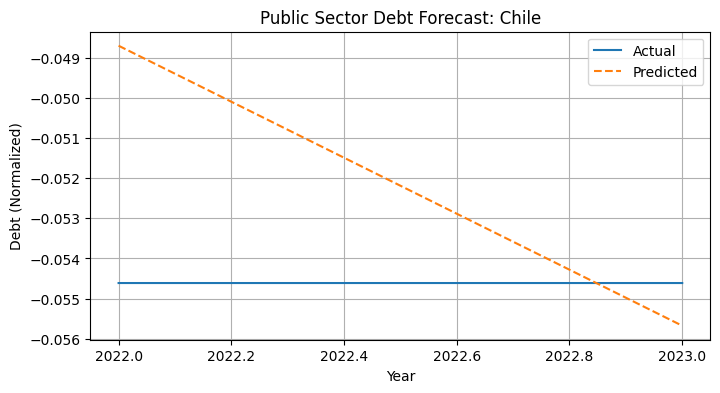

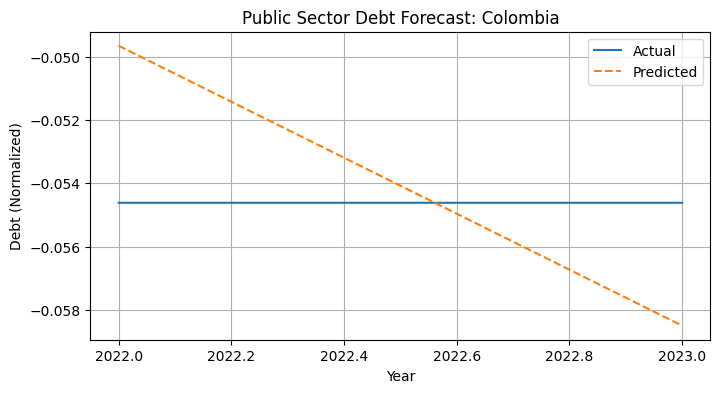

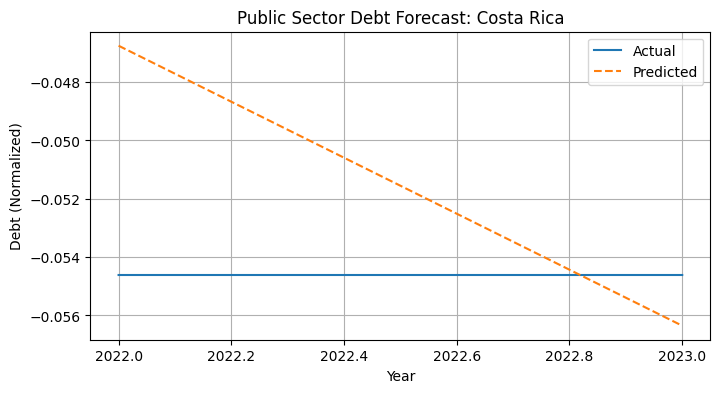

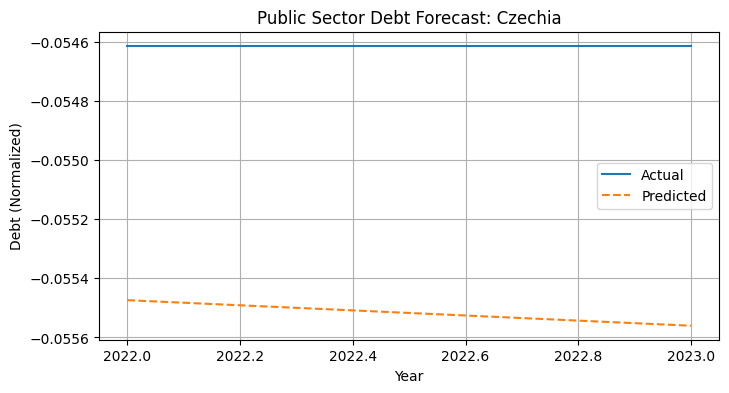

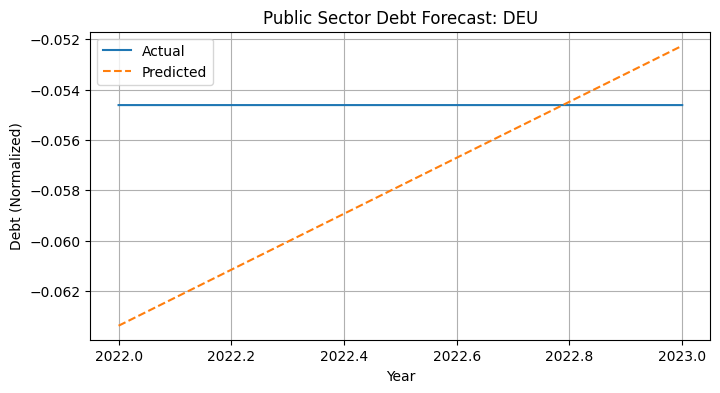

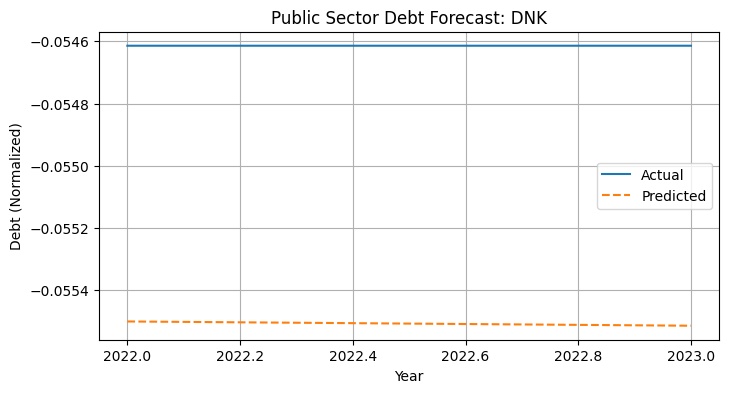

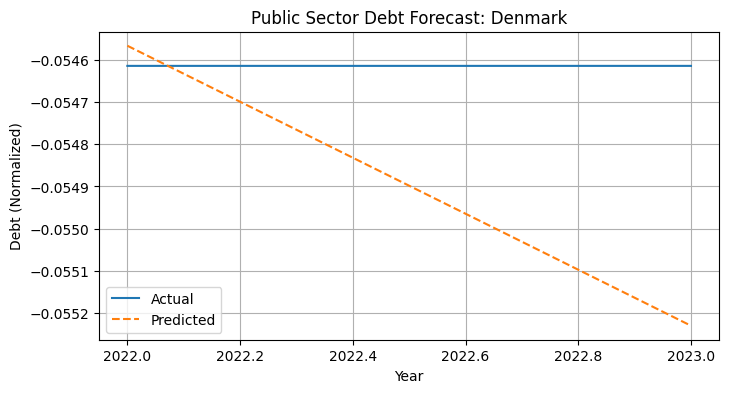

In [158]:
import matplotlib.pyplot as plt

# Choose a few countries to visualize
top_countries = results_df["Ccode"].value_counts().index[:20]

for country in top_countries:
    country_df = results_df[results_df["Ccode"] == country].sort_values("Year")
    plt.figure(figsize=(8, 4))
    plt.plot(country_df["Year"], country_df["Actual_Debt"], label="Actual")
    plt.plot(country_df["Year"], country_df["Predicted_Debt"], label="Predicted", linestyle="--")
    plt.title(f"Public Sector Debt Forecast: {country}")
    plt.xlabel("Year")
    plt.ylabel("Debt (Normalized)")  # or just "Debt"
    plt.legend()
    plt.grid(True)
    plt.show()



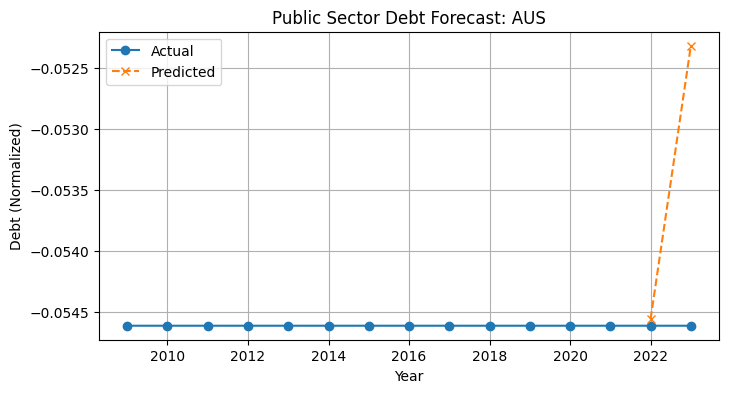

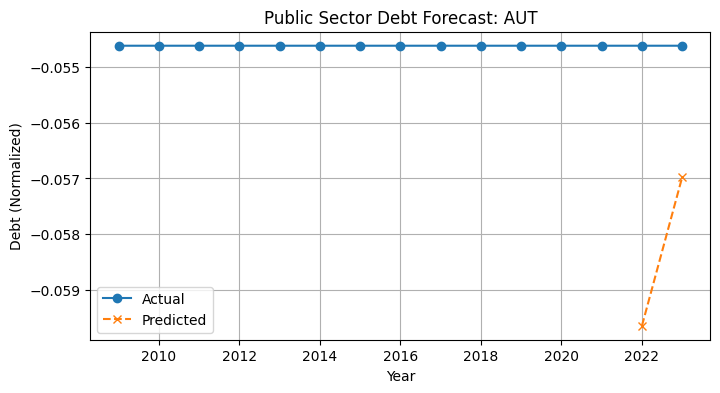

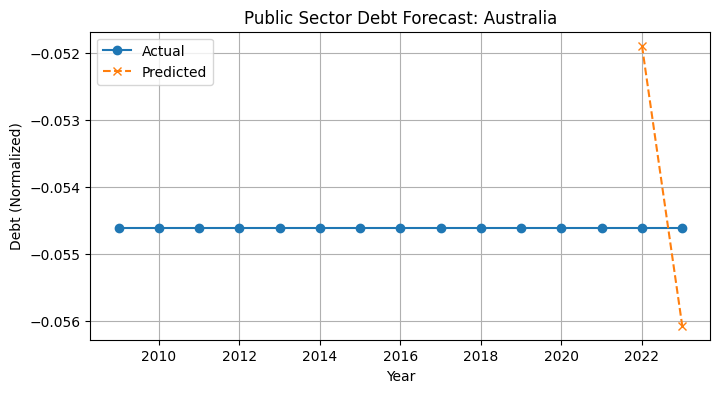

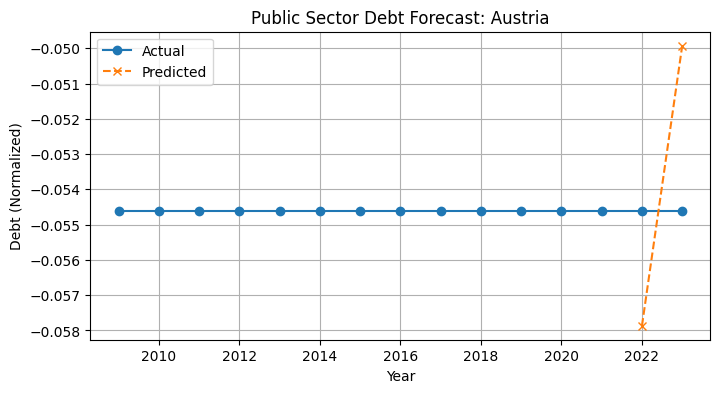

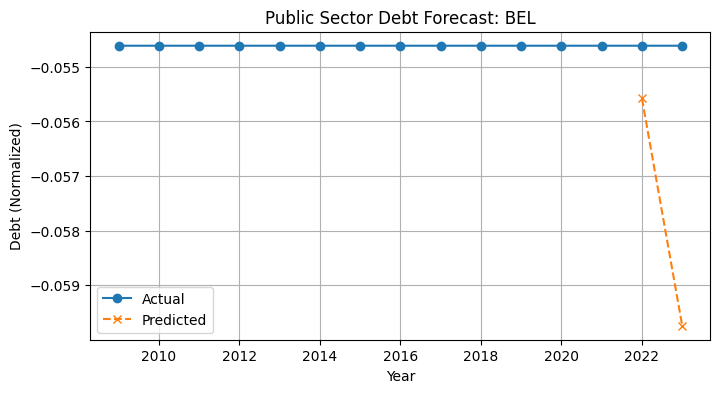

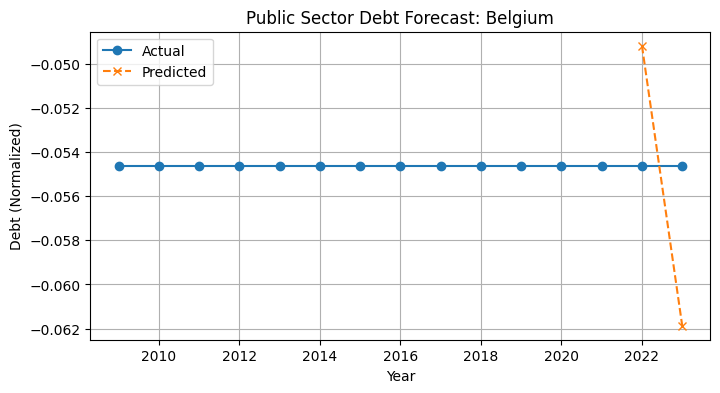

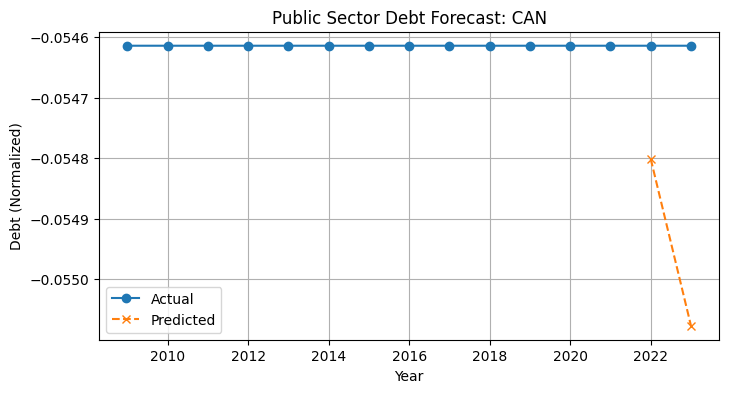

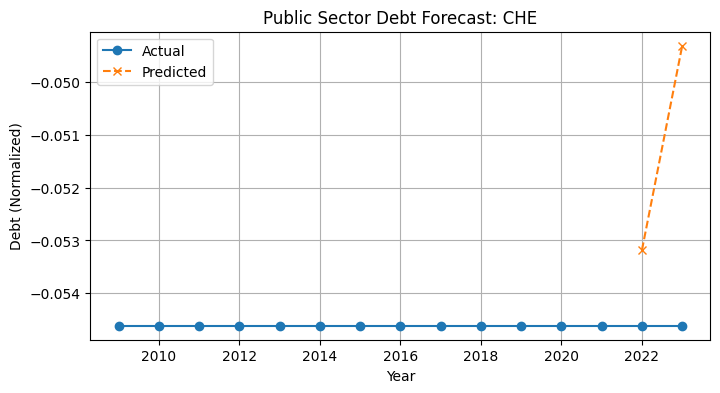

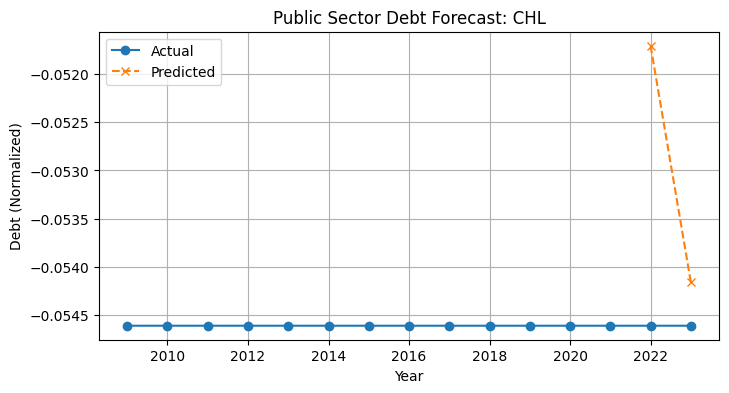

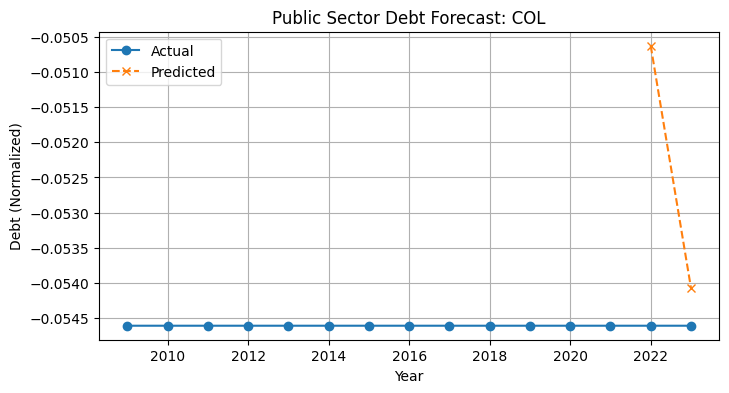

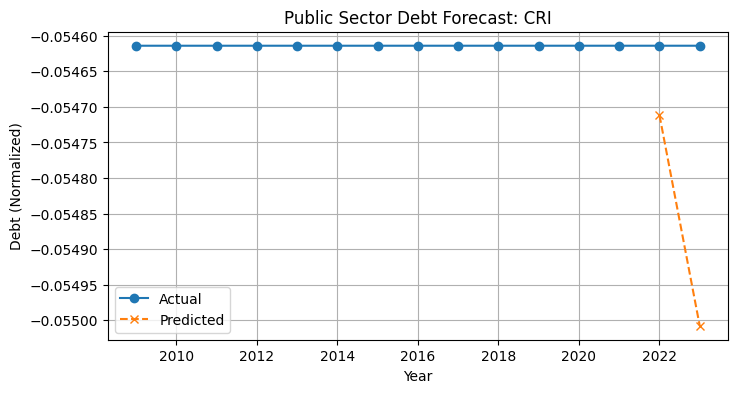

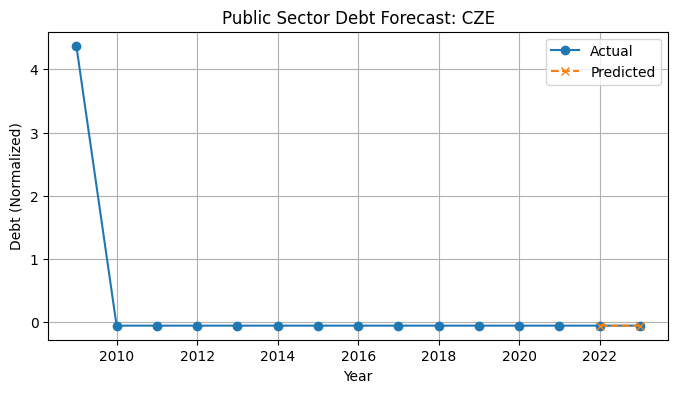

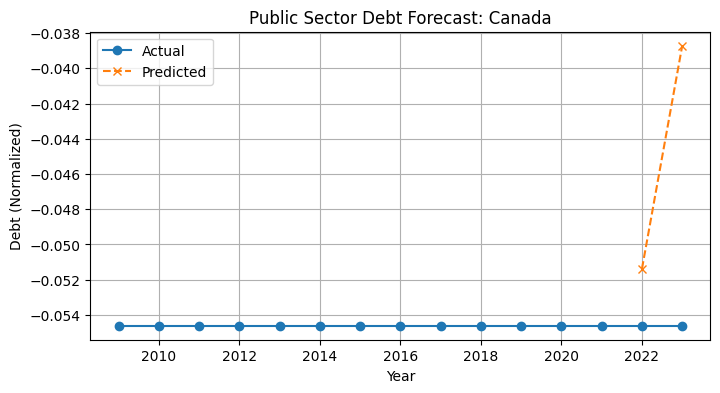

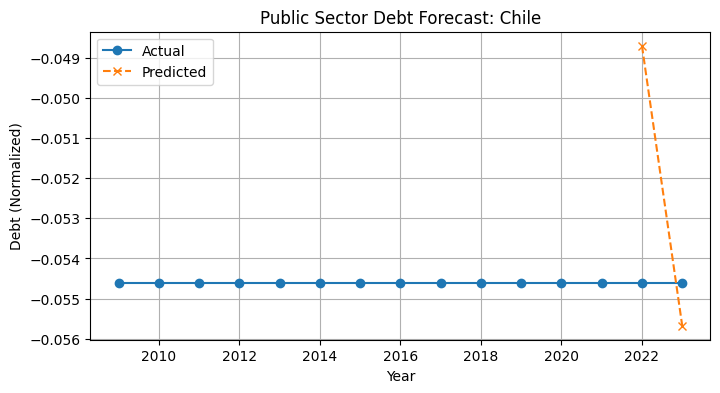

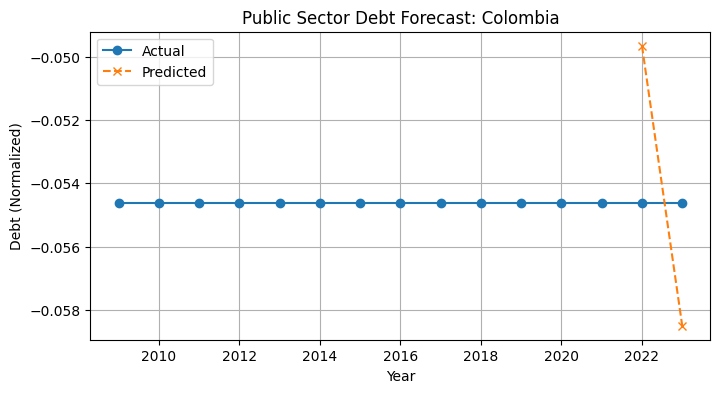

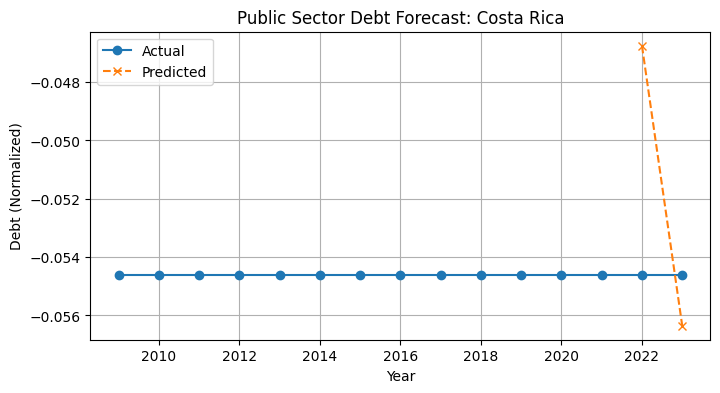

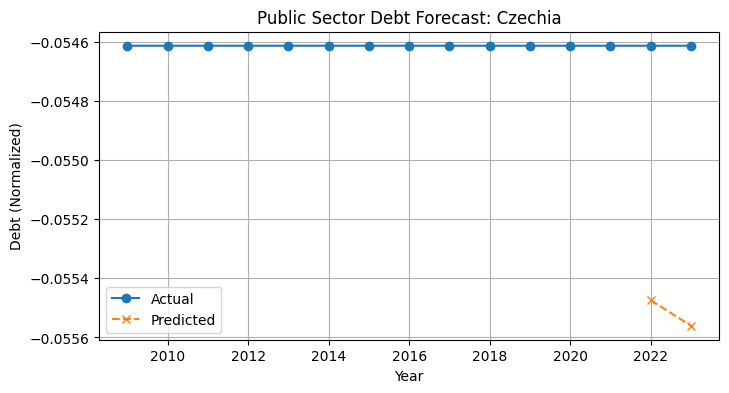

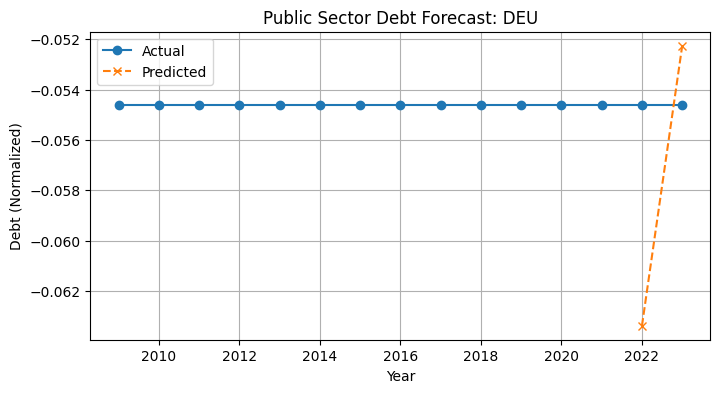

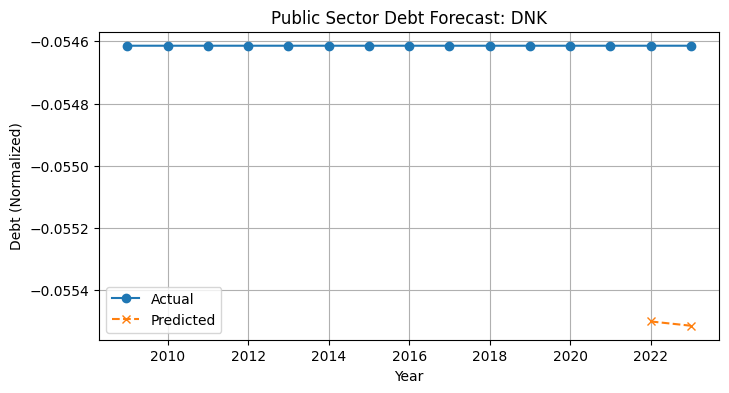

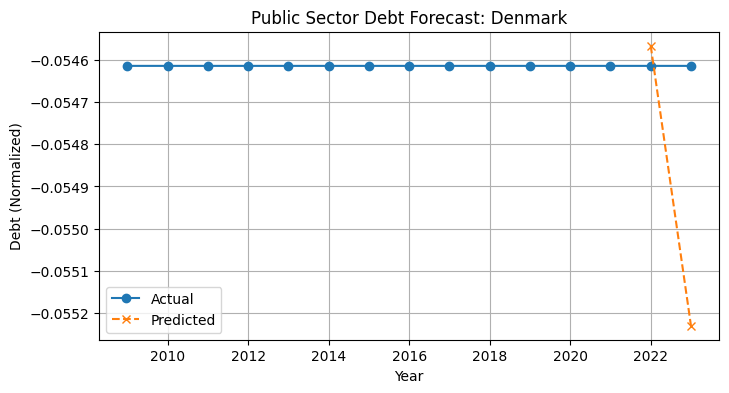

In [161]:
# Create long-form actuals
# For visualization, use the unscaled actual debt
actual_df = merged_df[["Ccode", "Year", "Actual_Debt_Unscaled"]].rename(columns={"Actual_Debt_Unscaled": "Actual_Debt"})

actual_df = merged_df[["Ccode", "Year", target_col]].copy()
actual_df = actual_df.rename(columns={target_col: "Actual_Debt"})

# Add predictions and concatenate
predicted_df = results_df[["Ccode", "Year", "Predicted_Debt"]]
full_df = pd.merge(actual_df, predicted_df, on=["Ccode", "Year"], how="outer")

# Sort properly
full_df = full_df.sort_values(["Ccode", "Year"])

# Plot
top_countries = full_df["Ccode"].value_counts().index[:20]

for country in top_countries:
    country_df = full_df[full_df["Ccode"] == country]
    plt.figure(figsize=(8, 4))

    if country_df["Actual_Debt"].notna().sum() > 0:
        plt.plot(country_df["Year"], country_df["Actual_Debt"], label="Actual", marker='o')

    if country_df["Predicted_Debt"].notna().sum() > 0:
        plt.plot(country_df["Year"], country_df["Predicted_Debt"], label="Predicted", linestyle="--", marker='x')

    plt.title(f"Public Sector Debt Forecast: {country}")
    plt.xlabel("Year")
    plt.ylabel("Debt (Normalized)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [160]:
merged_df.groupby("Ccode")["public sector debt_2009_2023.csv"].describe()


,count,mean,std,min,25%,50%,75%,max
Ccode,,,,,,,,
AUS,15.0,-0.054614,3.034733e-09,-0.054614,-0.054614,-0.054614,-0.054614,-0.054614
AUT,15.0,-0.054614,7.937995e-10,-0.054614,-0.054614,-0.054614,-0.054614,-0.054614
Australia,15.0,-0.054614,4.613683e-10,-0.054614,-0.054614,-0.054614,-0.054614,-0.054614
Austria,15.0,-0.054614,6.916524e-10,-0.054614,-0.054614,-0.054614,-0.054614,-0.054614
BEL,15.0,-0.054614,8.407964e-10,-0.054614,-0.054614,-0.054614,-0.054614,-0.054614
...,...,...,...,...,...,...,...,...
TUR,15.0,0.860610,3.544647e+00,-0.054614,-0.054614,-0.054614,-0.054614,13.673746
Turkey,15.0,-0.054614,5.615774e-09,-0.054614,-0.054614,-0.054614,-0.054614,-0.054614
USA,15.0,-0.054614,4.898580e-09,-0.054614,-0.054614,-0.054614,-0.054614,-0.054614
